<a href="https://colab.research.google.com/github/GeorgeKMaina/knn-naive-bayes/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TITANIC SURVIVAL PREDICTION- KNN Algorithm

## Defining the question

- To predict whether an individual survived based on the features in the dataset

##Metric for success

- This project will be considered successful if we are able to obtain a high accuracy score in our model (KNN) when predicting chances of survival of an individual in the titanic.

##Understanding the context

- The Titanic, during her maiden voyage on April 15, 1912, sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. The tragedy is considered one of the most infamous shipwrecks in history and led to better safety guidelines for ships.

- We shall analyse the data on passengers aboard the Titanic to build a model that can predict whether a passenger survived or not.

- We have two data sets. One for training (train.csv) containing survival and death information that we will use to train our model. One for testing (test.csv), without survival and death information, that we will use to test our models.

##Experimental design

- Defining the Question
- Reading the Data.
- Checking the Data.
- Data Cleaning
- Performing EDA
- Building thePrediction Model

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score

# Set global parameters
%matplotlib inline
sns.set()
plt.rcParams['figure.figsize'] = (10.0, 8.0)
warnings.filterwarnings('ignore')

In [2]:
# reading our csv files
train = pd.read_csv('/content/train (5).csv')
test = pd.read_csv('/content/test (1).csv')

In [3]:
# checking the top of our train dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# checking the bottom of train our dataset
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [5]:
# checking the data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Summary Statistics of the data
train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


# Data Cleaning

In [7]:
# making our columns uniform
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [8]:
# Checking for null values
train.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [9]:
# Dropping cabin column
train.drop( columns=['cabin'],inplace = True)
test.drop( columns=['cabin'],inplace = True)

In [10]:
# Replacing the null values in age column with the mean
train['age'] = train['age'].fillna(train['age'].mean())

In [11]:
# dealing with null values in embarked column
# There are only 2 null values. We will drop this 2 observations
train.dropna(inplace=True)
test.dropna(inplace=True)

(889, 11)


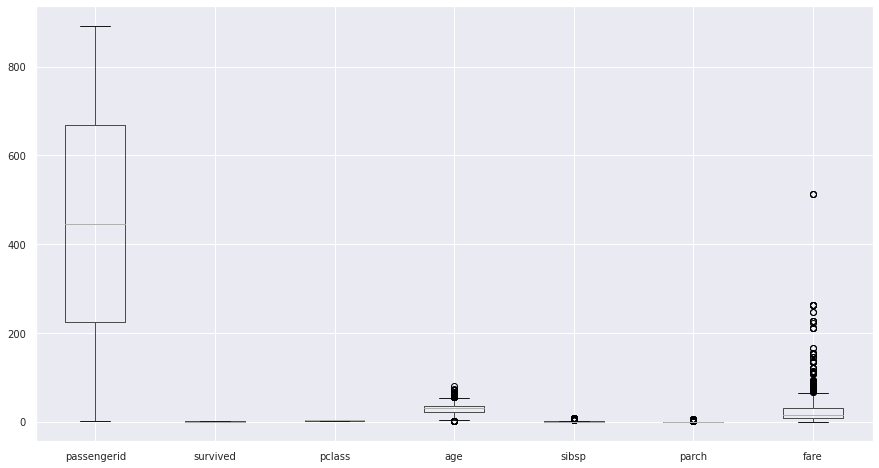

In [12]:
# Checking for outliers
# Checking for outliers using boxplots
train.boxplot(figsize=(15, 8), fontsize=10)

# print size of the data with outliers present
print(train.shape)

- The age column and fare have the most outlier values
- We will ignore them and proceed with the analysis 

# EDA

In [13]:
# Checking the frequency of the survived column
train.survived.value_counts(normalize=True)*100

0    61.754781
1    38.245219
Name: survived, dtype: float64

- 59.6% of the passengers on board did not survive
- 40.4% of the passengers on board survived

In [14]:
#checking what gender most passengerrs were
print('\n\nSex Ratio of individuals')
print(train['sex'].value_counts(normalize=True))




Sex Ratio of individuals
male      0.649044
female    0.350956
Name: sex, dtype: float64


- 63.6% of the passengers were men
- 36% of the passengers were ladies

In [15]:
#Checking for survival rates by gender
# we know women and children were given the first priority when being evacuated from the boat

#we will filter the dataset to get records of only those who survived
surv=train[train['survived']==1]

print('Survival Rate by Sex')
surv['survived'].groupby(surv['sex']).value_counts()

Survival Rate by Sex


sex     survived
female  1           231
male    1           109
Name: survived, dtype: int64

- The number of women who had boarded the titanic were less than that of men.
- Despite that fact, most women survived than men

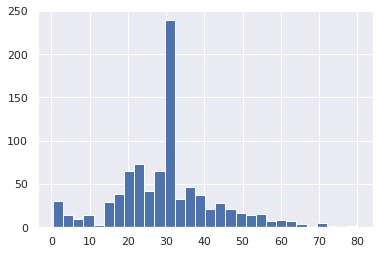

In [16]:
# plotting the passenger age historgram.
hist = train['age'].hist(bins=30)

- most of the passengers were young compare to the elderly

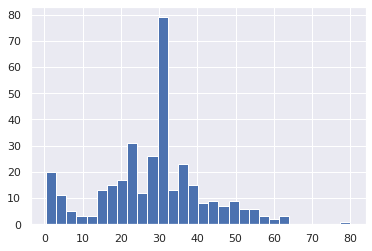

In [17]:
# survival rate by age
surv_age=surv['age'].hist(bins=30)

- most of the young people survived
- all the elderly people also survived
- Most of the passengers who survived were in their twenties and thirties
- None of the passengers in their seventies survived

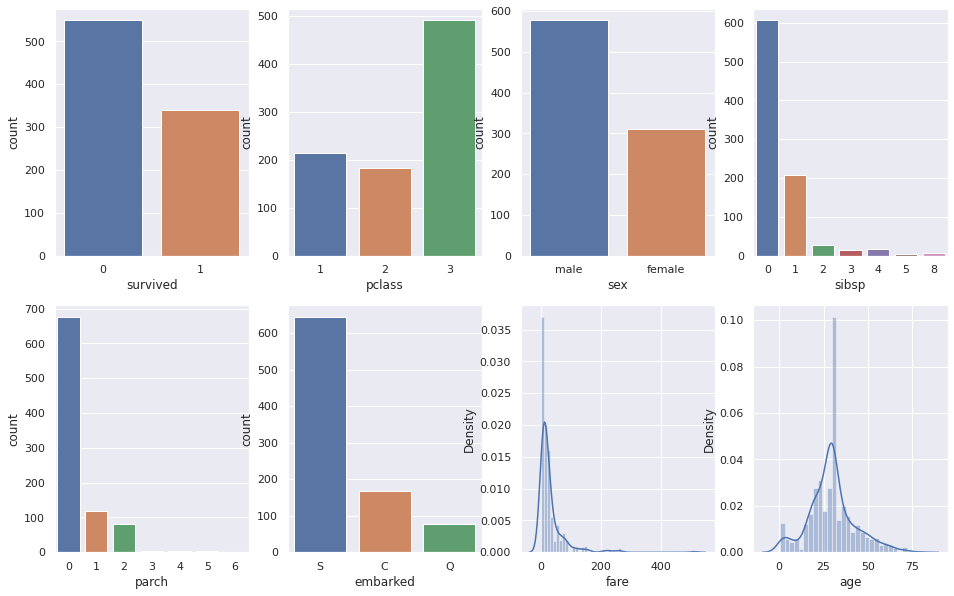

In [18]:
# plotting count plots of our features
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
sns.countplot('survived',data=train,ax=axes[0,0])
sns.countplot('pclass',data=train,ax=axes[0,1])
sns.countplot('sex',data=train,ax=axes[0,2])
sns.countplot('sibsp',data=train,ax=axes[0,3])
sns.countplot('parch',data=train,ax=axes[1,0])
sns.countplot('embarked',data=train,ax=axes[1,1])
sns.distplot(train['fare'], kde=True,ax=axes[1,2])
sns.distplot(train['age'],kde=True,ax=axes[1,3])

<Figure size 480x320 with 0 Axes>

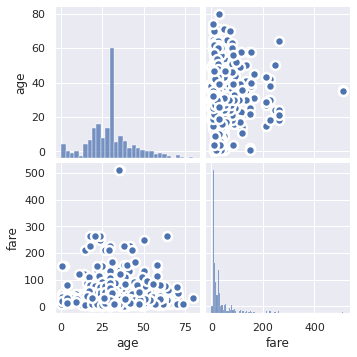

In [19]:
# plotting pairplots
plt.figure(dpi= 80)
sns.pairplot(train[['age','fare']], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

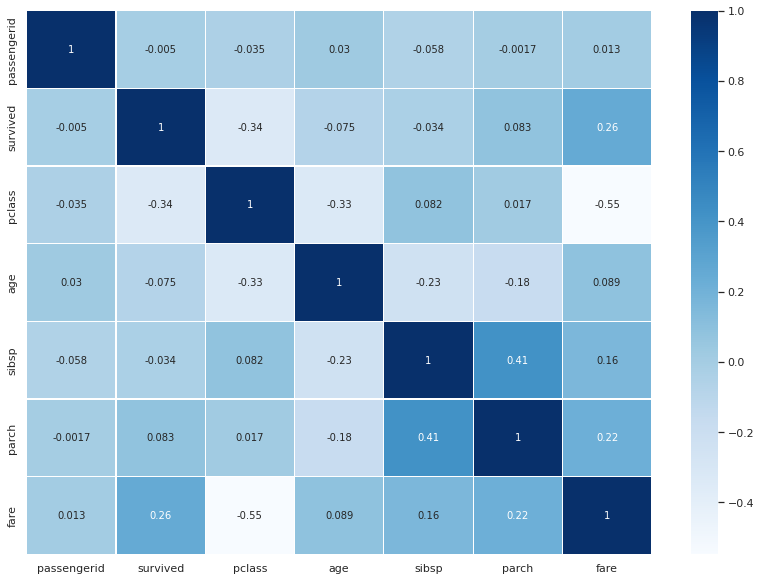

In [20]:
# correlation heatmap 
colormap = plt.cm.Blues
plt.figure(figsize=(14,10))
sns.heatmap(train.corr(), cmap=colormap, annot=True, linewidths=0.2)

- From the correlation map, we can see that p-class and fare are the columns with the highest correlation coefficient with our target variable

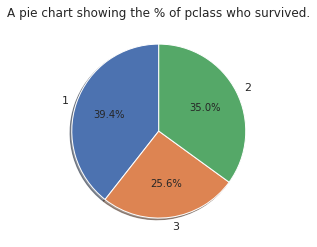

In [21]:
explode = [0,0,0]
p = surv.groupby('pclass')['survived'].value_counts()

labels = surv['pclass'].unique()

plt.title('A pie chart showing the % of pclass who survived.')
plt.pie(p,labels=labels,explode=explode,autopct='%1.1f%%',startangle=90,shadow=True);

- Most of the passengers who survived were in the first class of the titanic.

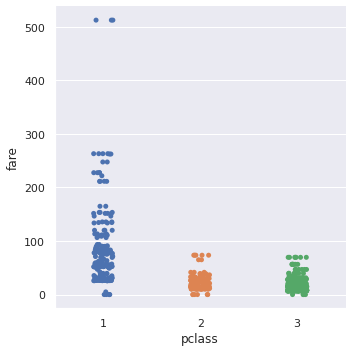

In [22]:
# Comparing class and fare
sns.catplot(x='pclass', y='fare', data=train)

- People in the first class paid high fares than those in the second and third class of the titanic

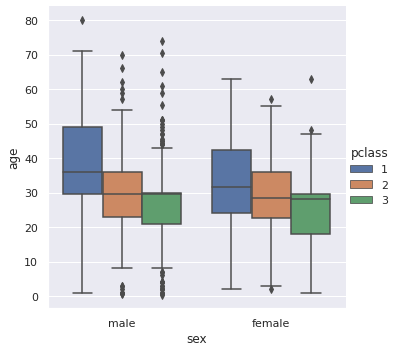

In [23]:
#Comparing sex and age and pclass
sns.catplot(x='sex', y='age', data=train, kind='box', hue='pclass')

- Majority of the elderly passengers were in the first class of the titanic

In [24]:
# What about the family's size? Would a larger family stand a better chance of survival?
train['family_members'] = train['parch'] + train['sibsp']
test['family_members'] = test['parch'] + test['sibsp']

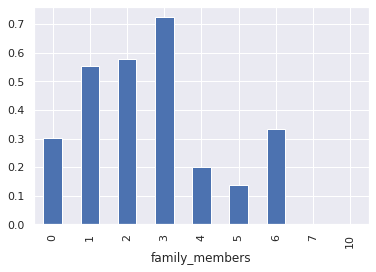

In [25]:
# Lets check family size
train['survived'].groupby(train['family_members']).mean().plot(kind='bar')

- small families had higher survival rates

In [26]:
# dropping columns we will not need 
train.drop(['name','sibsp','parch','passengerid','ticket'],axis=1,inplace=True)
test.drop(['name','sibsp','parch','passengerid','ticket'],axis=1,inplace=True)

In [27]:
train.columns

Index(['survived', 'pclass', 'sex', 'age', 'fare', 'embarked',
       'family_members'],
      dtype='object')

In [28]:
# Encode sex and embarked features
train['sex'] = train.sex.map({'male':0, 'female':1})
train['embarked'] = train.embarked.map({'C':0,'S':1,'Q':2})

test['sex'] = test.sex.map({'male':0, 'female':1})
test['embarked'] = test.embarked.map({'C':0,'S':1,'Q':2})

In [29]:
train.head()

,survived,pclass,sex,age,fare,embarked,family_members
0,0,3,0,22.0,7.2500,1,1
1,1,1,1,38.0,71.2833,0,1
2,1,3,1,26.0,7.9250,1,0
3,1,1,1,35.0,53.1000,1,1
4,0,3,0,35.0,8.0500,1,0


# Modelling

### Baseline

In [30]:
# Defining the predictor and target variables in our dataset.
#
X = train.drop(['survived'],axis=1)
y = train['survived']

# One hot encoding our data for the categorical variables
#
X = pd.get_dummies(X, drop_first=True)

# Splitting our dataset
#
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.2)

# Scaling the predictor variables
#
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Fitting the data in a logistic regression
#
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()
regressor.fit(X_train,y_train)

# Predicting classification using the test set
#
y_predict = regressor.predict(X_test)

# Getting the metrics for assessing our baseline model
#
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))

[[87 18]
 [31 42]]
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       105
           1       0.70      0.58      0.63        73

    accuracy                           0.72       178
   macro avg       0.72      0.70      0.71       178
weighted avg       0.72      0.72      0.72       178



Our model's accuracy is 72%, which is not high enough for us.

### K Nearest Neighbours

In [31]:
# Defining the predictor variables and target column
#
X = train.drop(['survived'],axis=1)
y = train['survived']
scaler = StandardScaler()
# Standardizing our numerical columns which are the age and fare columns
#
X[['age','fare']] = scaler.fit_transform(X[['age','fare']])

# One hot encoding any categorical columns in our dataset
#
X = pd.get_dummies(X, drop_first=True)

# Splitting our dataset into the test and train 
#
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=101)
 
# Choosing an odd number 3 to help us classify our data
#
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [32]:
# Predict new values using our test data
#
y_pred = classifier.predict(X_test)

# Printing out the various metrics
#
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[89 18]
 [19 52]]
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       107
           1       0.74      0.73      0.74        71

    accuracy                           0.79       178
   macro avg       0.78      0.78      0.78       178
weighted avg       0.79      0.79      0.79       178



- When using KNN classifier, the accuracy increased from 72% to 79%

In [33]:
# Hyperparameter tuning
#  Defining the hyper parameters for the Knearest Neighbors Classifier
#
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p = [1,2]
metric = ['manhattan', 'euclidean', 'minkowski']

# Creating a dictionary with the hyperparameters
#
hyperparameters = dict(leaf_size = leaf_size, n_neighbors = n_neighbors, p=p,metric = metric)

In [34]:
# Used GridSearch to look for the best parameters
classifier = KNeighborsClassifier()

clf = GridSearchCV(classifier, hyperparameters,cv=10)

In [35]:
# Fitting the train data into our model
#
clf.fit(X_train,y_train)
# Printing out the best parameters
#
clf.best_params_

{'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 22, 'p': 1}

In [36]:
# Fitting the parameters into our model
#
classifier = KNeighborsClassifier(leaf_size=10,n_neighbors=22,p=1,metric='manhattan')
classifier.fit(X_train,y_train)

KNeighborsClassifier(leaf_size=10, metric='manhattan', n_neighbors=22, p=1)

In [37]:
# Predicting values using our test set
#
y_predict = classifier.predict(X_test)

# Printing out the metrics for assessing the model's perfromance
#
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[89 18]
 [19 52]]
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       107
           1       0.74      0.73      0.74        71

    accuracy                           0.79       178
   macro avg       0.78      0.78      0.78       178
weighted avg       0.79      0.79      0.79       178



In [39]:
# Defining the list of test sizes we will use for the assessment
#
test_size = [0.1, 0.2, 0.3, 0.4, 0.5]

from sklearn import metrics
# Using a for loop to split the dataset, fit it with the optimal parameters then get the accuracy score.
#

for test in test_size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test, random_state = 12)
    
    # Fitting to the classifier
    classifier = KNeighborsClassifier(leaf_size=1,n_neighbors=29,p=1,metric='manhattan')
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)

    print("Test size {} has accuracy score:".format(test), (metrics.accuracy_score(y_test, y_pred)*100))

Test size 0.1 has accuracy score: 87.64044943820225
Test size 0.2 has accuracy score: 83.14606741573034
Test size 0.3 has accuracy score: 82.02247191011236
Test size 0.4 has accuracy score: 80.6179775280899
Test size 0.5 has accuracy score: 78.42696629213484


- Test size of 10 gives us the highest accuracy score